In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('data/olist_prepared_dataset.csv')

df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
# Convert date columns to datetime objects
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Engineer the target variable: delivery_time_days
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Clean the data: remove orders with no delivery date or negative delivery time
df.dropna(subset=['delivery_time_days'], inplace=True)
df = df[df['delivery_time_days'] >= 0]

numerical_features = ['freight_value', 'product_weight_g', 'product_volume_cm3']
categorical_features = ['seller_state', 'customer_state', 'product_category_name_english']
target = 'delivery_time_days'

X = df[numerical_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Data prepared for Delivery Time prediction.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Data prepared for Delivery Time prediction.
Training data shape: (90567, 6)
Testing data shape: (22642, 6)


In [3]:
# Model 1: Linear Regression (Baseline)
print("\nTraining Linear Regression...")
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr:.2f} days | R-squared: {r2_lr:.2f}")


Training Linear Regression...
Linear Regression MAE: 5.38 days | R-squared: 0.20


In [4]:
# Model 2: Random Forest Regressor (Tuning)
print("\nTuning Random Forest Regressor...")
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])
param_grid_rf = {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [10, 20]}
random_search_rf = RandomizedSearchCV(pipeline_rf, param_grid_rf, n_iter=2, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nBest Parameters for Random Forest:", random_search_rf.best_params_)
print(f"Tuned Random Forest MAE: {mae_rf:.2f} days | R-squared: {r2_rf:.2f}")


Tuning Random Forest Regressor...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best Parameters for Random Forest: {'regressor__n_estimators': 200, 'regressor__max_depth': 20}
Tuned Random Forest MAE: 4.88 days | R-squared: 0.28


In [5]:
# --- Model 3: XGBoost Regressor (Tuning) ---
print("\nTuning XGBoost Regressor...")
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(random_state=42))])
param_grid_xgb = {'regressor__n_estimators': [100, 500], 'regressor__learning_rate': [0.05, 0.1]}
random_search_xgb = RandomizedSearchCV(pipeline_xgb, param_grid_xgb, n_iter=2, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("\nBest Parameters for XGBoost:", random_search_xgb.best_params_)
print(f"Tuned XGBoost MAE: {mae_xgb:.2f} days | R-squared: {r2_xgb:.2f}")


Tuning XGBoost Regressor...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best Parameters for XGBoost: {'regressor__n_estimators': 500, 'regressor__learning_rate': 0.1}
Tuned XGBoost MAE: 4.99 days | R-squared: 0.27


-> Random Forest Regressor is best model for Delivery Time Prediction

Model Performance: The Tuned Random Forest Regressor demonstrated the best performance, achieving the lowest MAE of 4.88 days and the highest R² of 0.28. Both ensemble methods (Random Forest and XGBoost) significantly outperformed the Linear Regression baseline, indicating that the relationships between the features and the delivery time are predominantly non-linear.

Algorithmic Interpretation: The marginal performance difference between Random Forest and XGBoost suggests both models have a similar capacity to capture the patterns in this dataset. Random Forest's slight edge may indicate its robustness in this specific feature space; as a bagging model, it may have been less prone to overfitting on noisy logistical data compared to the sequential error-correcting approach of boosting used by XGBoost.

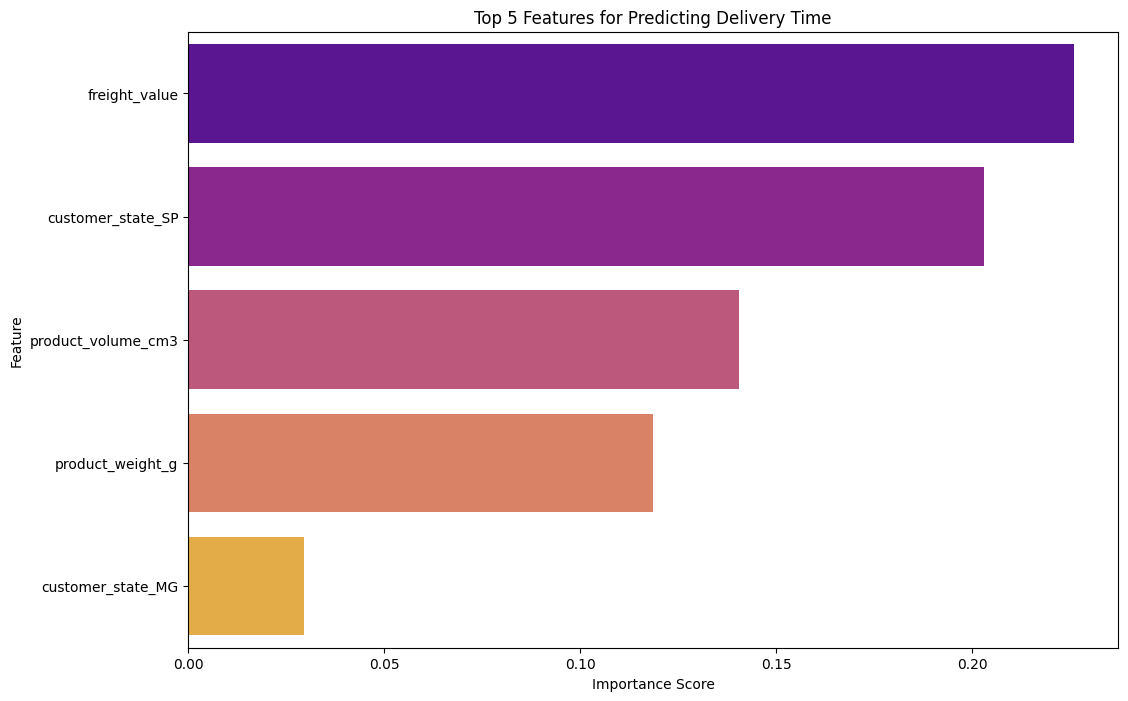


Top 3 most important features:
               feature  importance
0        freight_value    0.225960
50   customer_state_SP    0.202942
2   product_volume_cm3    0.140477


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

ohe_feature_names = best_rf.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Create a DataFrame of the feature importances
importances = best_rf.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot the Top 15 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(5), palette='plasma', hue='feature', legend=False)
plt.title('Top 5 Features for Predicting Delivery Time')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print("\nTop 3 most important features:")
print(feature_importance_df.head(3))

**freight value is the shipping cost that the customer paid to have their order delivered.

In [15]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# --- 1. Data Preparation ---
# Load the dataset
df = pd.read_csv('data/olist_prepared_dataset.csv')

# Engineer the 'product_volume_cm3' feature
df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

# Convert date columns and create the target variable 'delivery_time_days'
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Clean the data: remove orders with no delivery date or negative delivery time
df.dropna(subset=['delivery_time_days'], inplace=True)
df = df[df['delivery_time_days'] >= 0]

# Define features and target
numerical_features = ['freight_value', 'product_weight_g', 'product_volume_cm3']
categorical_features = ['seller_state', 'customer_state', 'product_category_name_english']
features = numerical_features + categorical_features
target = 'delivery_time_days'

X = df[features]
y = df[target]

print("Data prepared for final Delivery Time model training.")


# --- 2. Define and Train the Final Model ---

# Create preprocessing pipelines for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the final model pipeline, including the preprocessor and the regressor
# Use the best hyperparameters you found during your analysis
final_delivery_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,  # Best parameter from your analysis
        max_depth=20,       # Best parameter from your analysis
        random_state=42,
        n_jobs=-1
    ))
])

print("Training the final Random Forest model on the full dataset...")
# We train on the entire dataset (X, y) to make the model as robust as possible
final_delivery_model.fit(X, y)
print("Model training complete.")


# --- 3. Save the Model ---
# The entire pipeline (preprocessing + model) is saved to a single file.
file_path = 'models/delivery_model.pkl'
joblib.dump(final_delivery_model, file_path)

print(f"\nModel successfully saved to '{file_path}'")
print("\nThis file now contains your complete prediction pipeline and is ready for the Flask API.")

Data prepared for final Delivery Time model training.
Training the final Random Forest model on the full dataset...
Model training complete.

Model successfully saved to 'models/delivery_model.pkl'

This file now contains your complete prediction pipeline and is ready for the Flask API.
